[1.2342034047289652, 0.8339262435402591, 0.5979099219216477, 0.39247420825547574, 0.2525242645318454, 0.16017442237957713, 0.10106299614538981, 0.06358148956166684, 0.03995083909833199, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595105, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571365, 0.0009625497320203265, 0.0006040924319556741, 0.00037912574706291106, 0.00023793756048323344]


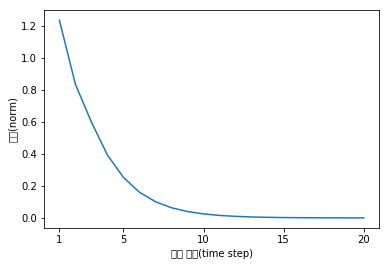

In [3]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))

np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정

#Wh = np.random.randn(H, H)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()


In [4]:
# coding: utf-8
import numpy as np


dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())


before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
after: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


In [5]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

In [ ]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.base_model import BaseModel


class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.lstm_layer.reset_state()


Done
| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.69
| 에폭 1 |  반복 21 / 1327 | 시간 9[s] | 퍼플렉서티 2965.93
| 에폭 1 |  반복 41 / 1327 | 시간 18[s] | 퍼플렉서티 1246.74
| 에폭 1 |  반복 61 / 1327 | 시간 27[s] | 퍼플렉서티 961.66
| 에폭 1 |  반복 81 / 1327 | 시간 36[s] | 퍼플렉서티 799.05
| 에폭 1 |  반복 101 / 1327 | 시간 45[s] | 퍼플렉서티 652.98
| 에폭 1 |  반복 121 / 1327 | 시간 54[s] | 퍼플렉서티 641.50
| 에폭 1 |  반복 141 / 1327 | 시간 63[s] | 퍼플렉서티 589.33
| 에폭 1 |  반복 161 / 1327 | 시간 72[s] | 퍼플렉서티 582.30
| 에폭 1 |  반복 181 / 1327 | 시간 81[s] | 퍼플렉서티 582.80
| 에폭 1 |  반복 201 / 1327 | 시간 90[s] | 퍼플렉서티 506.27
| 에폭 1 |  반복 221 / 1327 | 시간 100[s] | 퍼플렉서티 499.71
| 에폭 1 |  반복 241 / 1327 | 시간 109[s] | 퍼플렉서티 451.71
| 에폭 1 |  반복 261 / 1327 | 시간 117[s] | 퍼플렉서티 460.77
| 에폭 1 |  반복 281 / 1327 | 시간 126[s] | 퍼플렉서티 460.98
| 에폭 1 |  반복 301 / 1327 | 시간 135[s] | 퍼플렉서티 398.17
| 에폭 1 |  반복 321 / 1327 | 시간 144[s] | 퍼플렉서티 351.26
| 에폭 1 |  반복 341 / 1327 | 시간 153[s] | 퍼플렉서티 402.77
| 에폭 1 |  반복 361 / 1327 | 시간 162[s] | 퍼플렉서티 411.27
| 에폭 1 |  반복 381 / 1327 | 시간 171[s] | 퍼플렉서

| 에폭 3 |  반복 501 / 1327 | 시간 1440[s] | 퍼플렉서티 128.40
| 에폭 3 |  반복 521 / 1327 | 시간 1449[s] | 퍼플렉서티 140.30
| 에폭 3 |  반복 541 / 1327 | 시간 1459[s] | 퍼플렉서티 135.56
| 에폭 3 |  반복 561 / 1327 | 시간 1469[s] | 퍼플렉서티 119.02
| 에폭 3 |  반복 581 / 1327 | 시간 1479[s] | 퍼플렉서티 105.92
| 에폭 3 |  반복 601 / 1327 | 시간 1489[s] | 퍼플렉서티 148.37
| 에폭 3 |  반복 621 / 1327 | 시간 1499[s] | 퍼플렉서티 142.81
| 에폭 3 |  반복 641 / 1327 | 시간 1508[s] | 퍼플렉서티 129.47
| 에폭 3 |  반복 661 / 1327 | 시간 1517[s] | 퍼플렉서티 120.42
| 에폭 3 |  반복 681 / 1327 | 시간 1526[s] | 퍼플렉서티 100.30
| 에폭 3 |  반복 701 / 1327 | 시간 1535[s] | 퍼플렉서티 119.05
| 에폭 3 |  반복 721 / 1327 | 시간 1545[s] | 퍼플렉서티 124.66
| 에폭 3 |  반복 741 / 1327 | 시간 1553[s] | 퍼플렉서티 107.02
| 에폭 3 |  반복 761 / 1327 | 시간 1562[s] | 퍼플렉서티 102.22
| 에폭 3 |  반복 781 / 1327 | 시간 1571[s] | 퍼플렉서티 104.75
| 에폭 3 |  반복 801 / 1327 | 시간 1581[s] | 퍼플렉서티 116.64
| 에폭 3 |  반복 821 / 1327 | 시간 1589[s] | 퍼플렉서티 116.58
| 에폭 3 |  반복 841 / 1327 | 시간 1598[s] | 퍼플렉서티 114.91
| 에폭 3 |  반복 861 / 1327 | 시간 1607[s] | 퍼플렉서티 119.72
| 에폭 3 |  반복

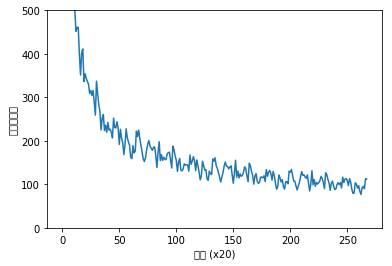

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼플렉서티:  135.8307456988957


In [7]:
# coding: utf-8
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
from ch06.rnnlm import Rnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()


In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
from common.time_layers import *
from common.np import *  # import numpy as np
from common.base_model import BaseModel


class BetterRnnlm(BaseModel):
    '''
     LSTM 계층을 2개 사용하고 각 층에 드롭아웃을 적용한 모델이다.
     아래 [1]에서 제안한 모델을 기초로 하였고, [2]와 [3]의 가중치 공유(weight tying)를 적용했다.

     [1] Recurrent Neural Network Regularization (https://arxiv.org/abs/1409.2329)
     [2] Using the Output Embedding to Improve Language Models (https://arxiv.org/abs/1608.05859)
     [3] Tying Word Vectors and Word Classifiers (https://arxiv.org/pdf/1611.01462.pdf)
    '''
    def __init__(self, vocab_size=10000, wordvec_size=650,
                 hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg

        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()


In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
# config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from ch06.better_rnnlm import BetterRnnlm


# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)


Done
| 에폭 1 |  반복 1 / 1327 | 시간 4[s] | 퍼플렉서티 10000.54
| 에폭 1 |  반복 21 / 1327 | 시간 94[s] | 퍼플렉서티 3975.31
| 에폭 1 |  반복 41 / 1327 | 시간 184[s] | 퍼플렉서티 1866.62
| 에폭 1 |  반복 61 / 1327 | 시간 276[s] | 퍼플렉서티 1268.60
| 에폭 1 |  반복 81 / 1327 | 시간 373[s] | 퍼플렉서티 1004.70
| 에폭 1 |  반복 101 / 1327 | 시간 462[s] | 퍼플렉서티 846.75
| 에폭 1 |  반복 121 / 1327 | 시간 559[s] | 퍼플렉서티 794.57
| 에폭 1 |  반복 141 / 1327 | 시간 649[s] | 퍼플렉서티 734.89
| 에폭 1 |  반복 161 / 1327 | 시간 738[s] | 퍼플렉서티 681.49
| 에폭 1 |  반복 181 / 1327 | 시간 829[s] | 퍼플렉서티 675.39
| 에폭 1 |  반복 201 / 1327 | 시간 920[s] | 퍼플렉서티 596.29
| 에폭 1 |  반복 221 / 1327 | 시간 1014[s] | 퍼플렉서티 572.91
| 에폭 1 |  반복 241 / 1327 | 시간 1124[s] | 퍼플렉서티 521.88
| 에폭 1 |  반복 261 / 1327 | 시간 1223[s] | 퍼플렉서티 531.76
| 에폭 1 |  반복 281 / 1327 | 시간 1320[s] | 퍼플렉서티 520.38
| 에폭 1 |  반복 301 / 1327 | 시간 1410[s] | 퍼플렉서티 442.67
| 에폭 1 |  반복 321 / 1327 | 시간 1502[s] | 퍼플렉서티 398.93
| 에폭 1 |  반복 341 / 1327 | 시간 1604[s] | 퍼플렉서티 452.82
| 에폭 1 |  반복 361 / 1327 | 시간 1705[s] | 퍼플렉서티 466.22
| 에폭 1 |  반복 381 / 13